# Dog vs Cat Image Classifier
Started with this notebook https://www.kaggle.com/uysimty/keras-cnn-dog-or-cat-classification

Import numpy, pandas, keras, and sklearn. matplotlib is just used for displaying graphs.

In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Verify equal spread between images of both dogs and cats in dataset.

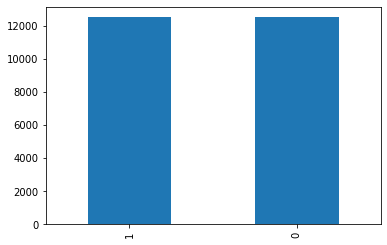

In [2]:
filenames = os.listdir("data/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df['category'].value_counts().plot.bar()

Display random image from the train dataset.

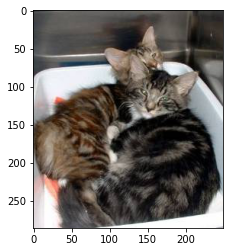

In [3]:
sample = random.choice(filenames)
image = load_img("data/train/"+sample)
plt.imshow(image)

## The Model

Uses a sequential model where the input later is 2D representing the image. The two layers after that are going to extract the features of the image. The output layer will be the prediction of either 1 for dog or 0 for cat. 

In [4]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

Sets values for stopping early to prevent over fitting. 

In [5]:
earlystop = EarlyStopping(patience=20)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [6]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

## Training Data Generator

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "data/train/",
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## Validation Data Generator

In [8]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "data/train/",
    x_col='filename',
    y_col='category',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## Fit the model for 30 epochs
Tested with multiple values from 20-50 epochs. 30 epochs seemed to return the most accurate results. 

In [9]:
epochs = 30
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/30
1333/1333 [==============================] - 600s 450ms/step - loss: 0.7655 - accuracy: 0.6169 - val_loss: 0.5702 - val_accuracy: 0.7111 - lr: 0.0010
Epoch 2/30
1333/1333 [==============================] - 598s 449ms/step - loss: 0.5896 - accuracy: 0.6998 - val_loss: 0.5351 - val_accuracy: 0.7333 - lr: 0.0010
Epoch 3/30
1333/1333 [==============================] - 594s 446ms/step - loss: 0.5491 - accuracy: 0.7292 - val_loss: 1.0168 - val_accuracy: 0.6214 - lr: 0.0010
Epoch 4/30
1333/1333 [==============================] - 593s 445ms/step - loss: 0.5195 - accuracy: 0.7502 - val_loss: 0.7365 - val_accuracy: 0.7025 - lr: 0.0010
Epoch 5/30
1333/1333 [==============================] - 594s 446ms/step - loss: 0.5027 - accuracy: 0.7610 - val_loss: 0.4682 - val_accuracy: 0.7892 - lr: 0.0010
Epoch 6/30
1333/1333 [==============================] - 594s 445ms/step - loss: 0.4891 - accuracy: 0.7701 - val_loss: 0.4729 - val_accuracy: 0.7758 - lr: 0.0010
Epoch 7/30
1333/1333 [============

1333/1333 [==============================] - 599s 450ms/step - loss: 0.3949 - accuracy: 0.8256 - val_loss: 0.4080 - val_accuracy: 0.8346 - lr: 0.0010
Epoch 22/30
1333/1333 [==============================] - 597s 448ms/step - loss: 0.3980 - accuracy: 0.8234 - val_loss: 0.6610 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 23/30
1333/1333 [==============================] - 596s 447ms/step - loss: 0.3895 - accuracy: 0.8282 - val_loss: 1.0837 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 24/30
1333/1333 [==============================] - 599s 450ms/step - loss: 0.3882 - accuracy: 0.8305 - val_loss: 0.3799 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 25/30
1333/1333 [==============================] - 600s 450ms/step - loss: 0.3883 - accuracy: 0.8290 - val_loss: 0.4705 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 26/30
1333/1333 [==============================] - 593s 445ms/step - loss: 0.3866 - accuracy: 0.8284 - val_loss: 0.3719 - val_accuracy: 0.8394 - lr: 0.0010
Epoch 27/30
1333/1333 [=================

## Save The Model

In [10]:
model.save_weights("model.h5")

## Plot Training Accuracy VS Validation Accuracy

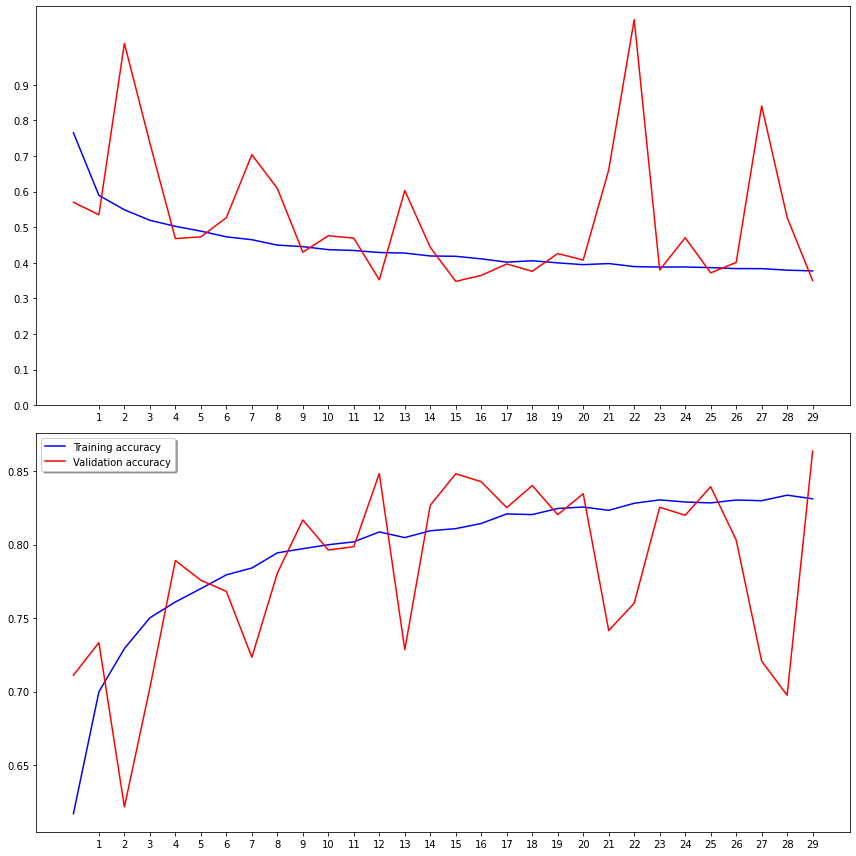

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Test Generator

In [12]:
test_filenames = os.listdir("data/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [13]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128, 128),
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [14]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

In [15]:
test_df['category'] = np.argmax(predict, axis=-1)

In [16]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

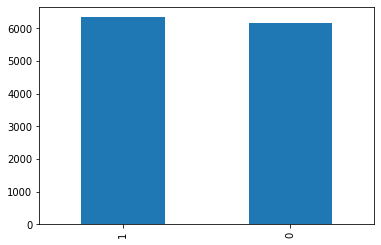

In [17]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'].value_counts().plot.bar()

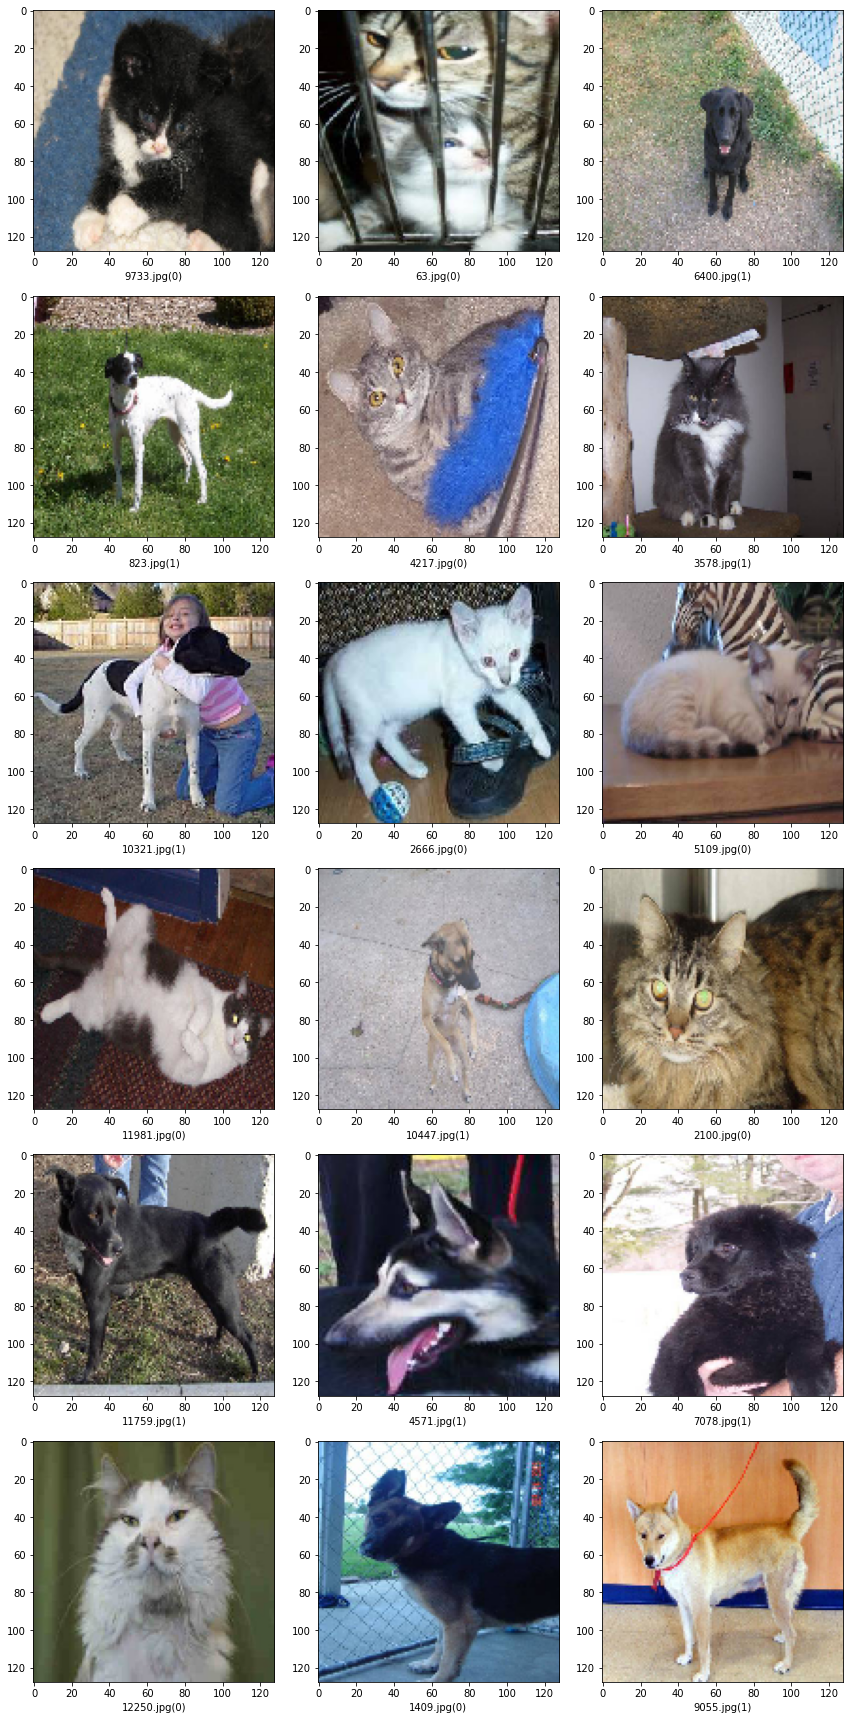

In [18]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("data/test/"+filename, target_size=(128, 128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()